In [8]:
!pip install geehydro -q
!pip install proplot -q
!pip install ipygee -q

     ---------------------------------------- 8.0/8.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 129.4/129.4 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 74.5/74.5 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ipygee: filename=ipygee-0.0.18-py3-none-any.whl size=41207 sha256=ed1f4d247fbdff75b26d257d8a047e1af73fcc02d68581129647408e2f7dc9e7
  Stored in directory: c:\users\fellipe\appdata\local\pip\cache\wheels\6c\50\ac\d40610837fb4e308655017ff83aa14f9cb45adcbbc5eb501f0
  Created wheel for geetools: filename=geetools-0.6.14-py3-none-any.whl size=92090 sha256=f6b2d8813434f003b4a4bfa81925a1806506d083f438d4439d442f733b1e5a5f
  Stored in directory: c:\users\fellipe\appdata\local\pip\cache\wheels\e9\a8\7f\40bf5aafcc334b20cd12d0328aff7861e8ea655c2

In [17]:
import ee
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
import geemap
import rasterio as rio
import pprint
import time
import gc
import numpy as np
import folium 
import geehydro
import seaborn as sns


from sklearn.preprocessing import Normalizer
from numpy import unique
from rasterio import features
from osgeo import gdal
from osgeo import osr
from datetime import datetime
from dateutil import relativedelta
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from ipygee import *


In [18]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [19]:
def maskEmptyPixels(image): 
  withObs = image.select('num_observations_1km').gt(0)
  return image.updateMask(withObs)


def maskClouds(image): 
  QA = image.select('state_1km')
  bitMask = 1 << 10
  return image.updateMask(QA.bitwiseAnd(bitMask).eq(0))

collection = ee.ImageCollection('MODIS/006/MOD09GA')\
        .filterDate('2010-04-01', '2010-05-01')\
        .map(maskEmptyPixels)

totalObsCount = collection\
        .select('num_observations_1km')\
        .count()

collectionCloudMasked = collection.map(maskClouds)

clearObsCount = collectionCloudMasked\
        .select('num_observations_1km')\
        .count()\
        .unmask(0)
        

# Create a default map
Map = geemap.Map()
Map.addLayer(
    collectionCloudMasked.median(),
    {'bands': ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'],
     'gain': 0.07,
     'gamma': 1.4
    },
    'median of masked collection'
  )
Map.addLayer(
    totalObsCount,
    {'min': 84, 'max': 92},
    'count of total observations',
    False
  )
Map.addLayer(
    clearObsCount,
    {'min': 0, 'max': 90},
    'count of clear observations',
    False
  )
Map.addLayer(
    clearObsCount.toFloat().divide(totalObsCount),
    {'min': 0, 'max': 1},
    'ratio of clear to total observations'
  )
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [20]:
x1,y1,x2,y2= -55.3800349723379242,-8.0051619964282423,-54.7129565837871183,-7.5177835013920964

geometria = ee.Geometry.Polygon(
        [[[float(x1),float(y2)],
          [float(x2),float(y2)],
          [float(x2),float(y1)],
          [float(x1),float(y1)],
          [float(x1),float(y2)]]])

def scale_factor(image):
    # scale factor for the MODIS MOD13Q1 product
    return image.multiply(0.0001).copyProperties(image, 
                                             ['system:time_start'])
# Dataset 
image = ee.ImageCollection("MODIS/006/MOD13Q1")\
        .filterDate('2000-02-18','2005-01-01')\
        .map(scale_factor)\
        .median()\
        .clip(geometria)

bands = ['EVI', 'NDVI']

image = image.select(bands)
# Select all bands and NDVI for the classification
#print(image.bandNames().getInfo())


# Perform K-means clustering
training_dataset = image.sample(
    **{
        'scale': 250,
        'numPixels': 500,
        'seed': 0,
        'geometries': True,  # Set this to False to ignore geometries
    }
)


clusters_kmeans = ee.Clusterer.wekaKMeans(9).train(training_dataset)

# Classify the image
classified = image.cluster(clusters_kmeans)

# Create a mask for each of the 8 clusters
mask0 = classified.eq(0)
mask1 = classified.eq(1)
mask2 = classified.eq(2)
mask3 = classified.eq(3)
mask4 = classified.eq(4)
mask5 = classified.eq(5)
mask6 = classified.eq(6)
mask7 = classified.eq(7)
mask8 = classified.eq(8)



masks = [mask0, mask1, mask2, mask3, mask4, mask5, mask6, mask7, mask8]


In [21]:
# Create a default map
Map = geemap.Map()
Map.addLayer(masks[0], {'palette': ['white', 'black']}, 'Cluster '+ str(0))
Map.addLayer(masks[1], {'palette': ['white', 'black']}, 'Cluster '+ str(1))
Map.addLayer(masks[2], {'palette': ['white', 'black']}, 'Cluster '+ str(2))
Map.addLayer(masks[3], {'palette': ['white', 'black']}, 'Cluster '+ str(3))
Map.addLayer(masks[4], {'palette': ['white', 'black']}, 'Cluster '+ str(4))
Map.addLayer(masks[5], {'palette': ['white', 'black']}, 'Cluster '+ str(5))
Map.addLayer(masks[6], {'palette': ['white', 'black']}, 'Cluster '+ str(6))
Map.addLayer(masks[7], {'palette': ['white', 'black']}, 'Cluster '+ str(7))
Map.addLayer(classified.randomVisualizer(), {} , 'teste')
#Map.addLayer(mask0.randomVisualizer(), {} , 'mask')

# Display the map
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [22]:
# Dataset 
IMAGE_COLLECTION = ee.ImageCollection("MODIS/006/MOD13Q1")\
        .filterDate('2000-02-18','2022-01-01')\
        .map(scale_factor)

IMAGE_COLLECTION = IMAGE_COLLECTION.map(lambda img: img.addBands(classified))


In [28]:
NDVI = chart.Image.series(**{'imageCollection': IMAGE_COLLECTION.select('NDVI'), 
                                   'region': geometria, 
                                   'reducer': ee.Reducer.mean(), 
                                   'scale': 1000, 
                                   'xProperty' : 'system:time_start'})
NDVI.renderWidget(width='100%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

<AxesSubplot: ylabel='NDVI'>

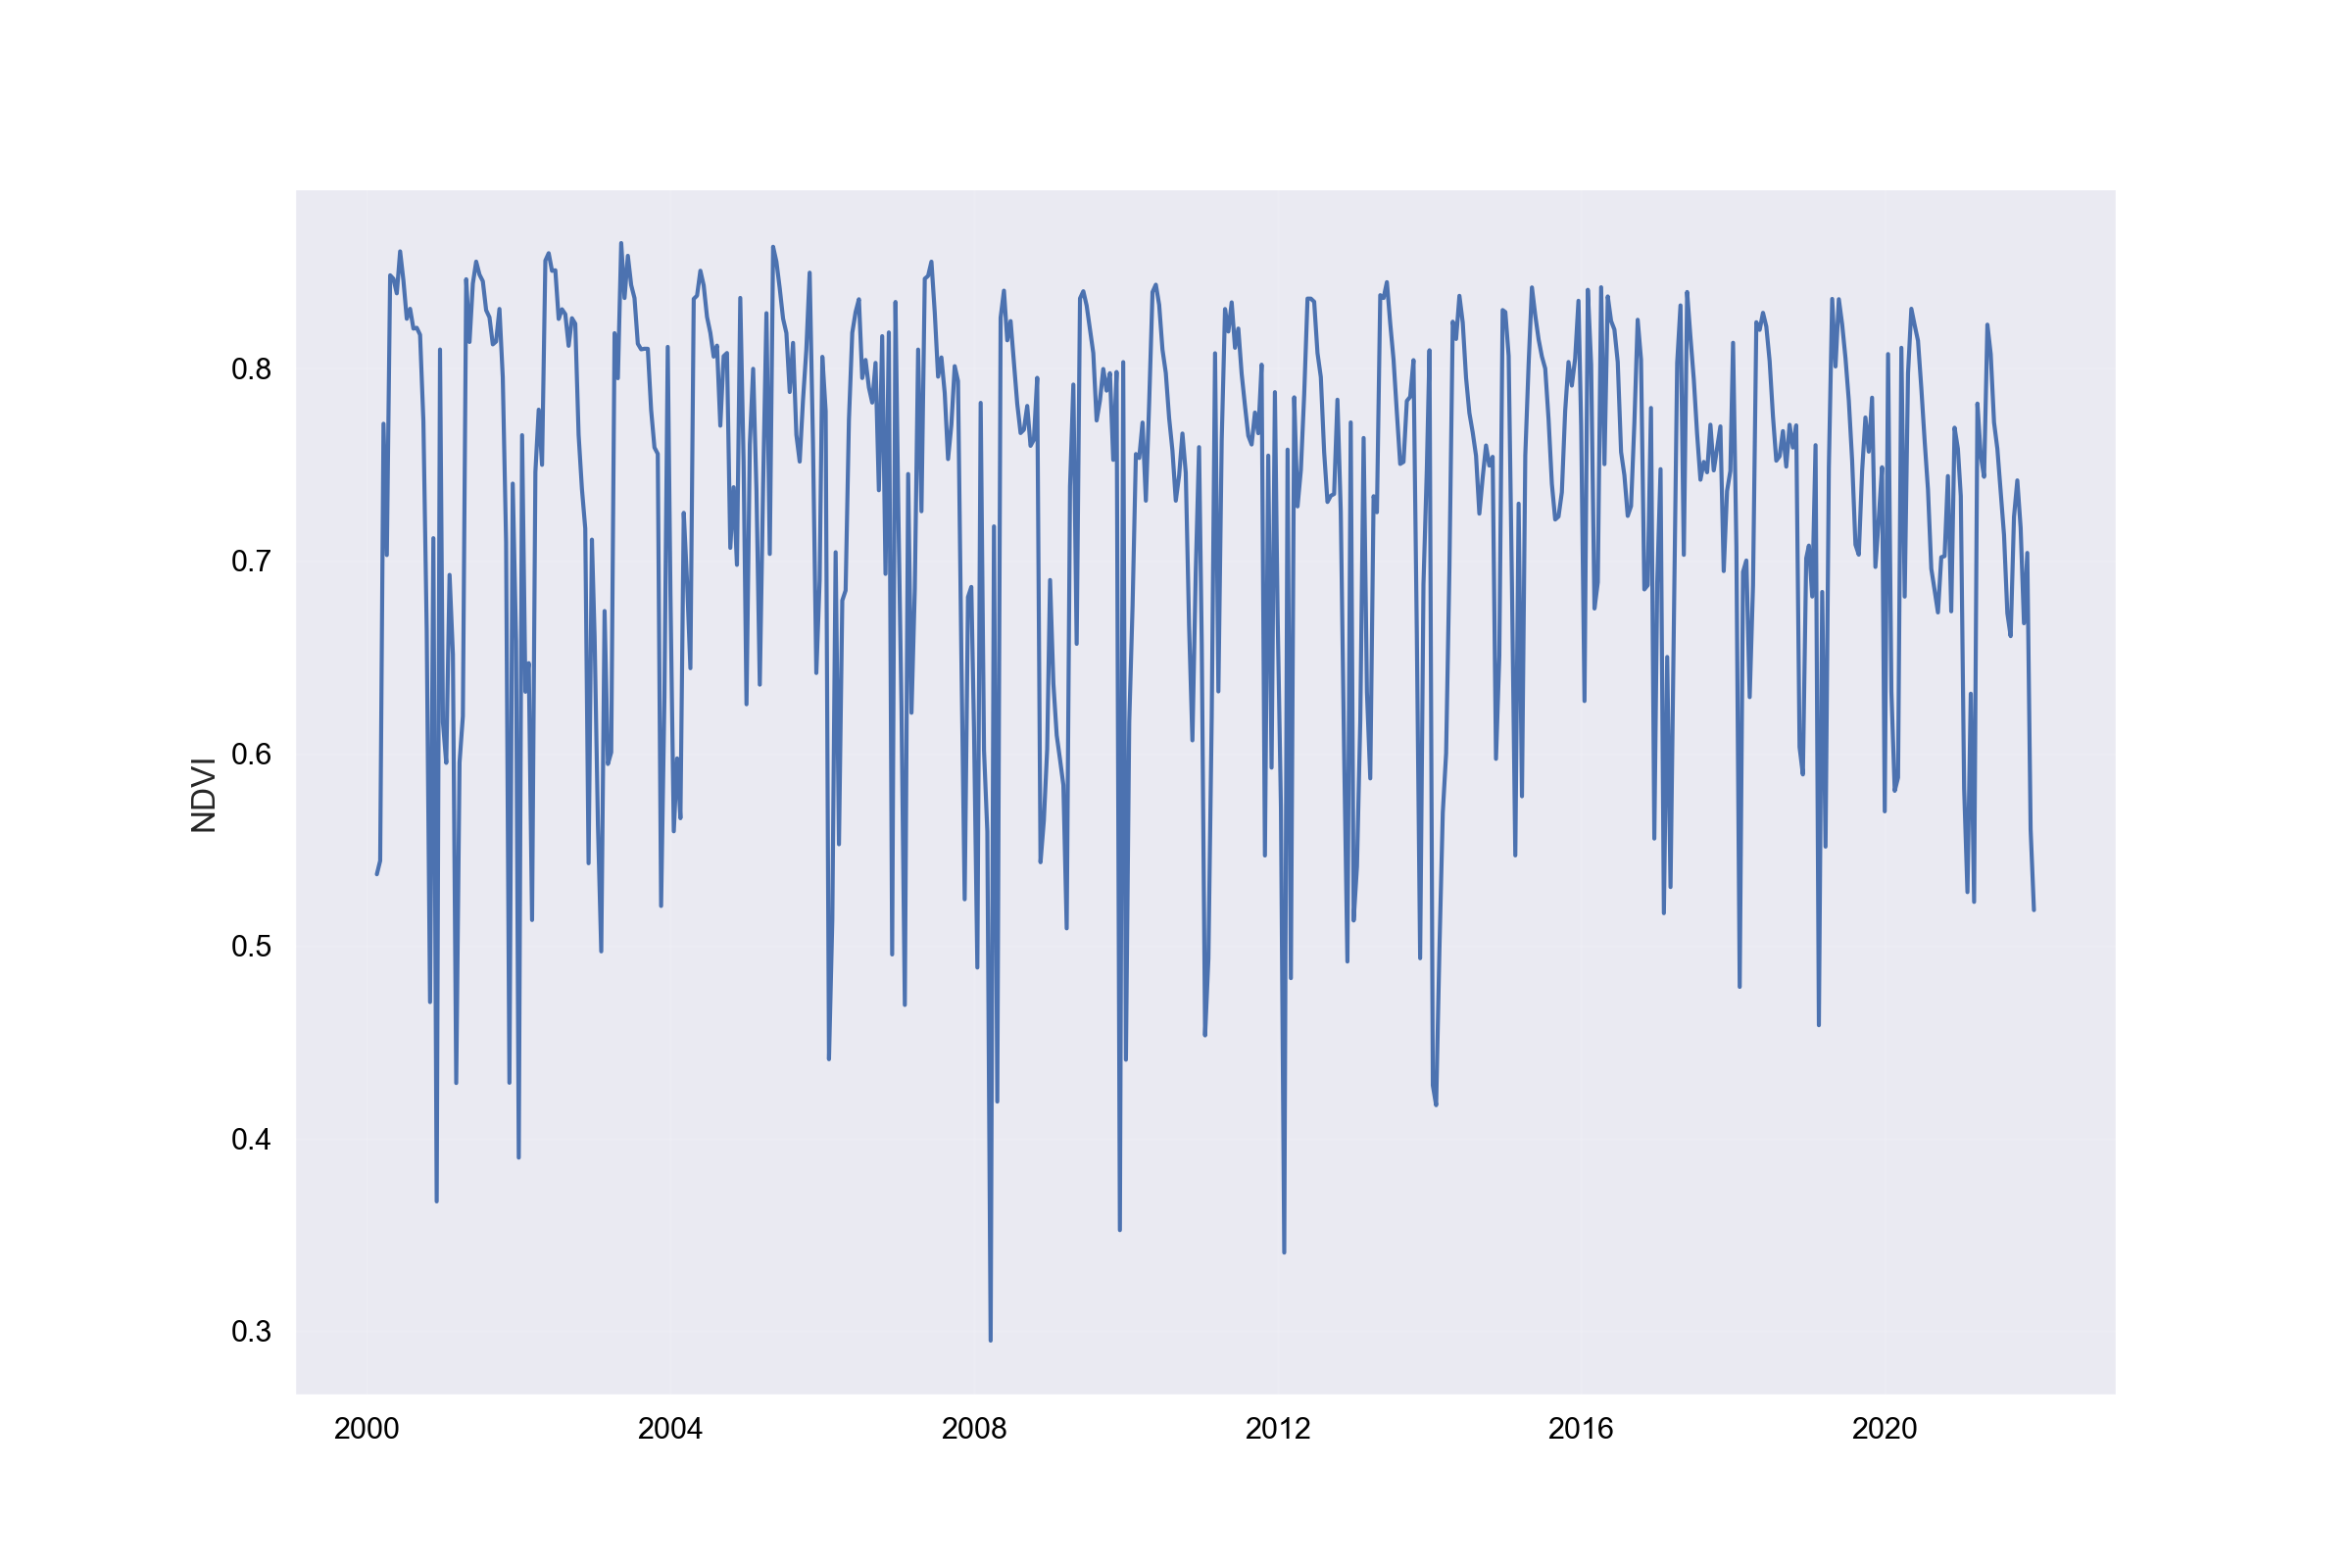

In [27]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=NDVI.dataframe.index,
            y=NDVI.dataframe['NDVI'],
            data=NDVI) 

In [29]:
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Jdate'] = pd.DatetimeIndex(df['Timestamp']).to_julian_date()
  return df


def fc_to_dict(fc):
  
  prop_names = fc.first().propertyNames()

  prop_lists = fc.reduceColumns(

      reducer=ee.Reducer.toList().repeat(prop_names.size()),

      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)


def create_reduce_region_function(geometry,
                                  reducer,
                                  scale = 250,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):

  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)
    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})  
  return reduce_region_function

In [30]:
for i in range(0,len(masks)):
  
  masked = IMAGE_COLLECTION.map(lambda img: img.updateMask(masks[i]))
  
  reduce_b = create_reduce_region_function(
  geometry = masks[i].geometry(), reducer=ee.Reducer.stdDev(), scale=250)

  b_stat_fc = ee.FeatureCollection(masked.map(reduce_b)).filter(
  ee.Filter.notNull(masked.first().bandNames()))
  
  dict = fc_to_dict(b_stat_fc).getInfo()
  
  df = pd.DataFrame(dict)
  df = add_date_info(df)
  
  name_file = 'df_std'+str(i)+'.csv'
  df.to_csv(name_file)
  print('df'+str(i))

In [ ]:
for i in range(0,len(masks)):
  
  masked = IMAGE_COLLECTION.map(lambda img: img.updateMask(masks[i]))
  
  reduce_b = create_reduce_region_function(
  geometry = masks[i].geometry(), reducer=ee.Reducer.median(), scale=250)

  b_stat_fc = ee.FeatureCollection(masked.map(reduce_b)).filter(
  ee.Filter.notNull(masked.first().bandNames()))
  
  dict = fc_to_dict(b_stat_fc).getInfo()
  
  df = pd.DataFrame(dict)
  df = add_date_info(df)
  
  name_file = 'df_median'+str(i)+'.csv'
  df.to_csv(name_file)
  print('df'+str(i))